# Different Approach for Explainability

This code was used to experiment with different explainable machine learning techniques,like LIME w. FNN, to interpret the decisions of our models.

In the final report, the results we presented and discussed mainly come from:
EBM models applied to TF-IDF and Word2Vec features and we comment on LIME explanations applied to the FNN model using TF-IDF and BERT features (Part E: Explainable ML -> LIME on FNN).

While we explored all three methods during development, only the results from EBM and LIME on FNN predictions were directly included in our final analysis and comparisons.


### Installations

In [ ]:
!pip install transformers
!pip install torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.5 MB/s eta 0:00:00


In [ ]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d8f4f9bfc7c156820842a0591a54cddd390da1afb4a44da87cbb79b6777a4ff8
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
#BERT:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
#Random forest:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
#FFN
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
#Multimodal ML
import re
from sklearn.feature_selection import SelectKBest, f_regression
#Explainable ML
from lime.lime_tabular import LimeTabularExplainer

## Load data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = "/content/drive/MyDrive/ML/HW4/MITInterview/"

Mounted at /content/drive


In [ ]:
trancripts_csv = pd.read_csv(folder_path + "transcripts.csv", header=None, names=["Participant", "Transcripts"])
scores_csv = pd.read_csv(folder_path + "scores.csv")
scores_csv.columns

Index(['Participant', 'Overall', 'Excited'], dtype='object')

In [ ]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set correct local path (update to match your own structure)
folder_path = "/content/drive/MyDrive/ML/HW4/MITInterview/"

# Load CSV files
transcripts_csv = pd.read_csv(folder_path + "transcripts.csv", header=None, names=["Participant", "Transcripts"])
scores_csv = pd.read_csv(folder_path + "scores.csv")

# Display column names of scores
print(scores_csv.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['Participant', 'Overall', 'Excited'], dtype='object')


## A: Extracting language features + B: Language Feature Selection

### TF-IDF:

In [ ]:
df_merge = pd.merge(trancripts_csv, scores_csv, on="Participant", how='inner')

#Split into train and test
train_df, test_df = train_test_split(df_merge, test_size=0.1, random_state=42) #test set is 10% of data

# Fit TF-IDF only on training data
tfidf = TfidfVectorizer(stop_words='english', max_features=500)

tfidf = TfidfVectorizer(stop_words='english', max_features=500)
X_train = tfidf.fit_transform(train_df['Transcripts'])
X_train_tfidf = X_train.toarray()

X_test = tfidf.transform(test_df['Transcripts']) #Use same fitted vectorizer to transform test dat
X_test_tfidf = X_test.toarray()

#Get target labels for both training and test set
y_train_excited = train_df['Excited']
y_test_excited = test_df['Excited']

y_train_overall = train_df['Overall']
y_test_overall = test_df['Overall']

#### Pearson filtering:

In [ ]:
correlations = []
X_array = X_train.toarray()
feature_names = tfidf.get_feature_names_out()

for i in range(X_array.shape[1]):
    r_excited, _ = pearsonr(X_array[:, i], y_train_excited)
    r_overall, _ = pearsonr(X_array[:, i], y_train_overall)
    correlations.append((feature_names[i], r_excited, r_overall))

df_corr = pd.DataFrame(correlations, columns=["Word", "r_excited", "r_overall"])

#Filtering for Excited:
k = 50  #Can change
top_k_excited = df_corr.reindex(df_corr["r_excited"].abs().sort_values(ascending=False).index).head(k)
selected_words_excited = top_k_excited["Word"].tolist()

#Get indices of top-k words
selected_indices_excited = [list(feature_names).index(word) for word in selected_words_excited]

#Slice the X_array
X_train_filtered = X_array[:, selected_indices_excited]
X_test_filtered = X_test.toarray()[:, selected_indices_excited]

# Filtering for Overall
top_k_overall = df_corr.reindex(df_corr["r_overall"].abs().sort_values(ascending=False).index).head(k)
selected_words_overall = top_k_overall["Word"].tolist()
selected_indices_overall = [list(feature_names).index(word) for word in selected_words_overall]

X_train_overall = X_array[:, selected_indices_overall]
X_test_overall = X_test.toarray()[:, selected_indices_overall]

##### Visualize:

<ipython-input-10-d8aa43b80328>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_excited, x='r_excited', y='Word', palette='coolwarm')


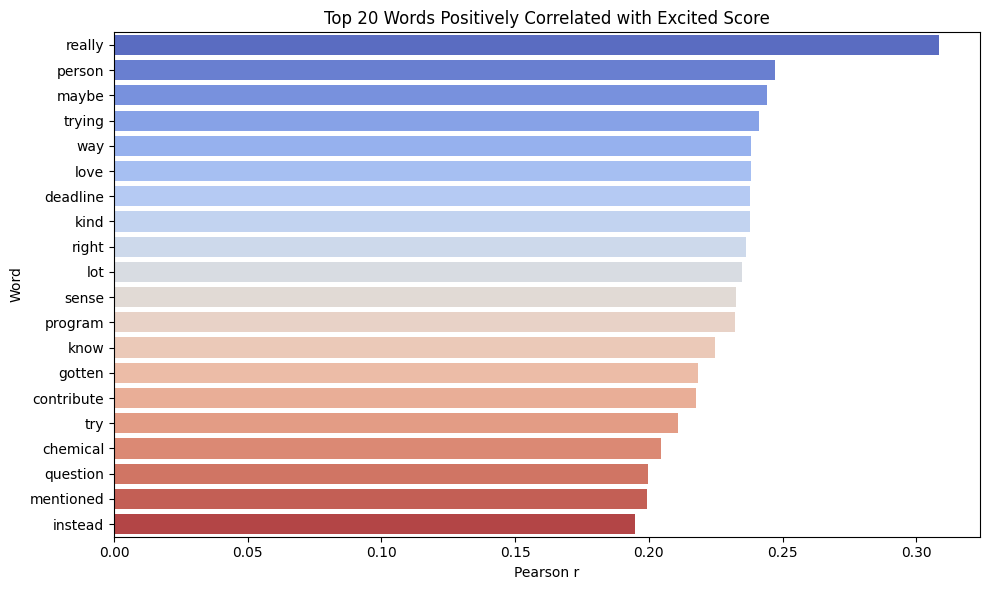

<ipython-input-10-d8aa43b80328>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_overall, x='r_overall', y='Word', palette='coolwarm')


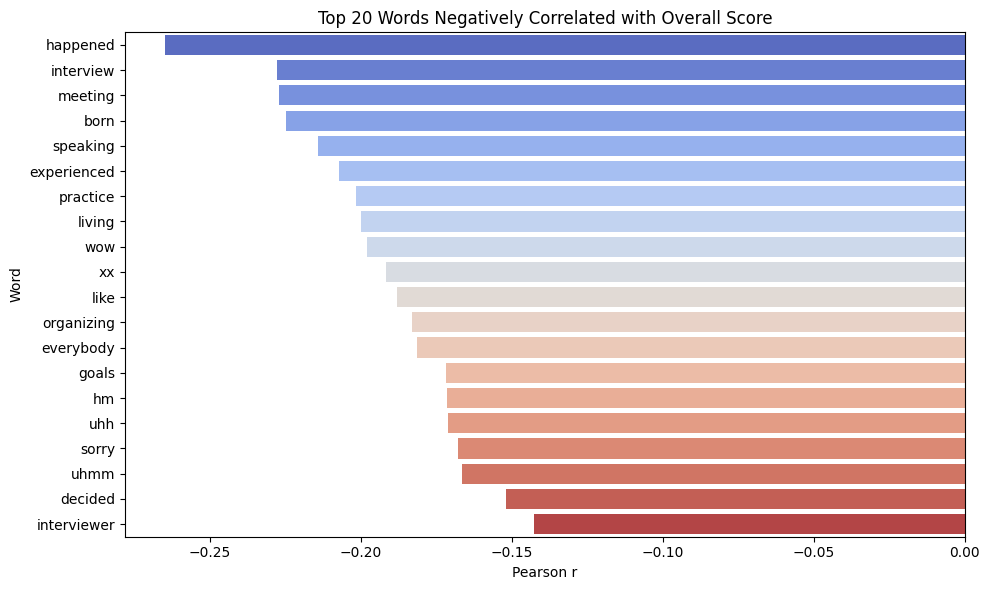

In [ ]:
#Visualize before filtering - positive and negative correlation
top_excited = df_corr.sort_values(by='r_excited', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_excited, x='r_excited', y='Word', palette='coolwarm')
plt.title("Top 20 Words Positively Correlated with Excited Score")
plt.xlabel("Pearson r")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

bottom_overall = df_corr.sort_values(by='r_overall').head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=bottom_overall, x='r_overall', y='Word', palette='coolwarm')
plt.title("Top 20 Words Negatively Correlated with Overall Score")
plt.xlabel("Pearson r")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

<ipython-input-11-30421786f3f9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_k_excited.head(20), x="r_excited", y="Word", palette="coolwarm")


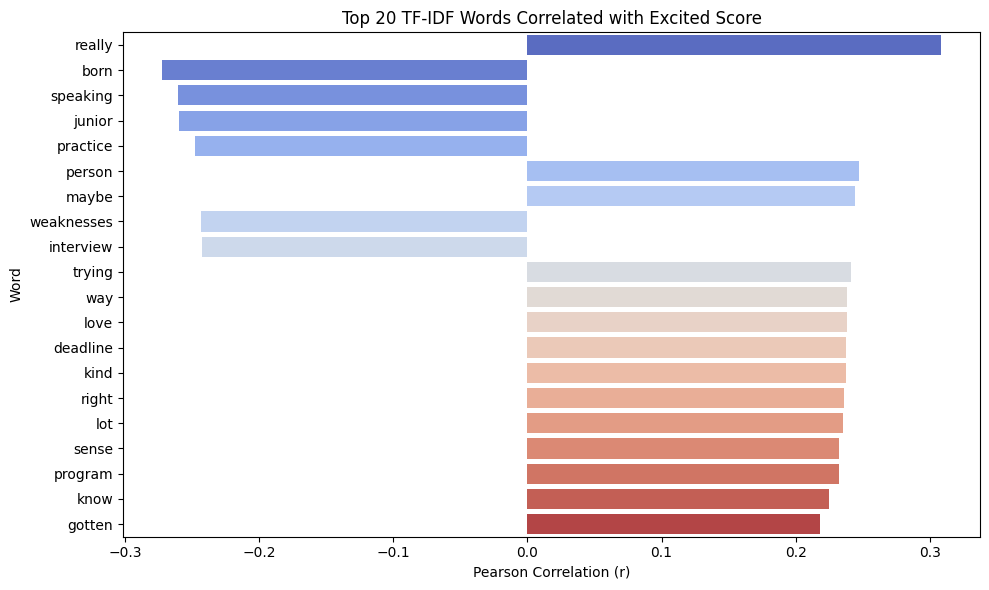

<ipython-input-11-30421786f3f9>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_k_overall.head(20), x="r_overall", y="Word", palette="coolwarm")


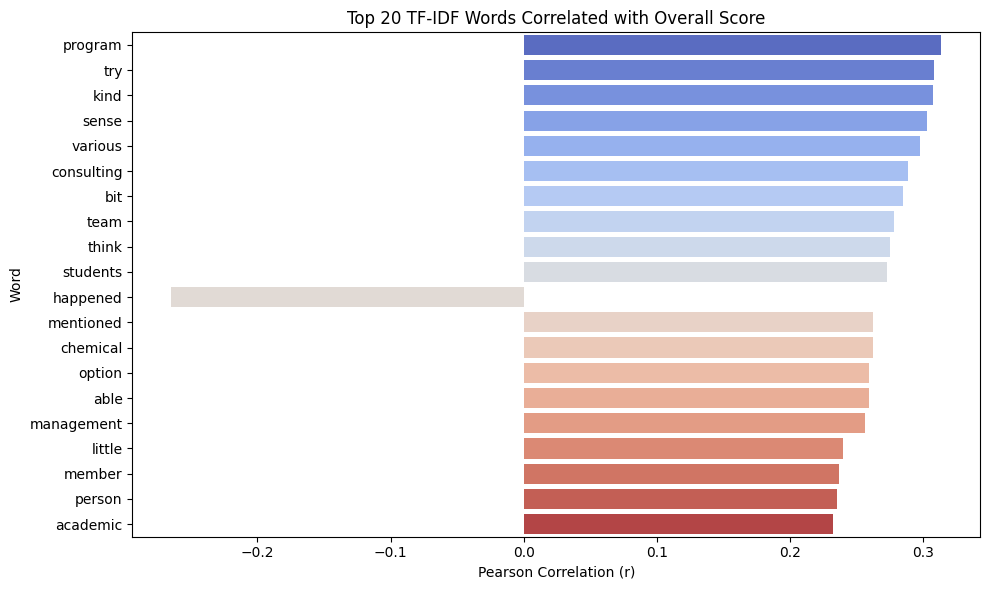

In [ ]:
#Visualize after filtering - absolute cirrelation
plt.figure(figsize=(10, 6))
sns.barplot(data=top_k_excited.head(20), x="r_excited", y="Word", palette="coolwarm")
plt.title("Top 20 TF-IDF Words Correlated with Excited Score")
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_k_overall.head(20), x="r_overall", y="Word", palette="coolwarm")
plt.title("Top 20 TF-IDF Words Correlated with Overall Score")
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

### BERT:

In [ ]:
#Load pretrained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

#Get transcripts
transcripts = df_merge["Transcripts"].tolist()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
#Function that gets BERT embeddings:
def get_bert_embedding(text, tokenizer, model):
    with torch.no_grad():
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        output = model(**encoded_input)
        embeddings = output.last_hidden_state.mean(dim=1).squeeze()#Mean pooling on last hidden state
    return embeddings.numpy()

train_df, test_df = train_test_split(df_merge, test_size=0.1, random_state=42)

#Train set
train_embeddings = [get_bert_embedding(text, tokenizer, bert_model) for text in tqdm(train_df["Transcripts"])]
X_train_bert = np.stack(train_embeddings)

#Test set
test_embeddings = [get_bert_embedding(text, tokenizer, bert_model) for text in tqdm(test_df["Transcripts"])]
X_test_bert = np.stack(test_embeddings)

#Targets
y_train_excited = train_df['Excited'].values
y_test_excited = test_df['Excited'].values
y_train_overall = train_df['Overall'].values
y_test_overall = test_df['Overall'].values


100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


#### Pearson Filtering

In [ ]:
#Pearson filtering
correlations_bert = []
for i in range(X_train_bert.shape[1]):
    r_excited, _ = pearsonr(X_train_bert[:, i], y_train_excited)
    r_overall, _ = pearsonr(X_train_bert[:, i], y_train_overall)
    correlations_bert.append((f"dim_{i}", i, r_excited, r_overall))

df_bert_corr = pd.DataFrame(correlations_bert, columns=["Feature", "Index", "r_excited", "r_overall"])

#Select top-k
k = 50
top_k_dims = df_bert_corr.reindex(df_bert_corr["r_excited"].abs().sort_values(ascending=False).index).head(k)
selected_dims = top_k_dims["Index"].tolist()

X_train_bert_filtered = X_train_bert[:, selected_dims]
X_test_bert_filtered = X_test_bert[:, selected_dims]

##### Visualize:

<ipython-input-15-f3e4f2e179b0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


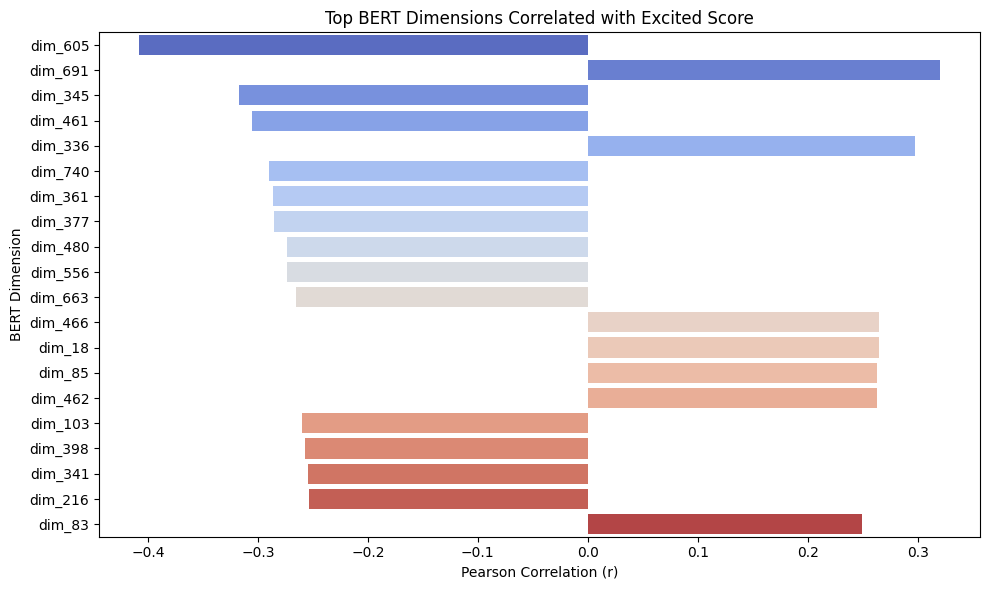

<ipython-input-15-f3e4f2e179b0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


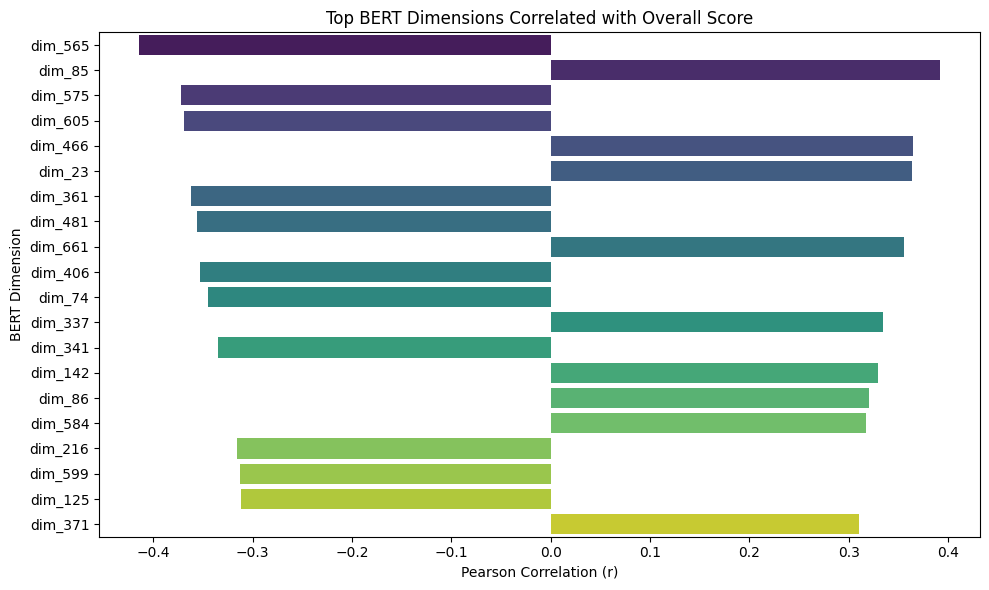

In [ ]:
# Plot the top k BERT dimensions sorted by r_excited
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_k_dims.head(20),
    x="r_excited",
    y="Feature",
    palette="coolwarm"
)
plt.title("Top BERT Dimensions Correlated with Excited Score")
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("BERT Dimension")
plt.tight_layout()
plt.show()

#Top k BERT dimensions correlated with overall score
top_k_dims_overall = df_bert_corr.reindex(
    df_bert_corr["r_overall"].abs().sort_values(ascending=False).index
).head(k)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_k_dims_overall.head(20),
    x="r_overall",
    y="Feature",
    palette="viridis"
)
plt.title("Top BERT Dimensions Correlated with Overall Score")
plt.xlabel("Pearson Correlation (r)")
plt.ylabel("BERT Dimension")
plt.tight_layout()
plt.show()

## C: Estimating interview outcomes based on language

In [ ]:
#Prepare data
from sklearn.model_selection import KFold

#Training set
X_train_af = X_train_bert
y_train_excited = train_df["Excited"].values
y_train_overall = train_df["Overall"].values

#Test set
X_test_af = X_test_bert
y_test_excited = test_df["Excited"].values
y_test_overall = test_df["Overall"].values



### Random forest

In [ ]:


def train_rf(X, y):
  kf = KFold(n_splits=5, shuffle=True, random_state=42)#5-fold cross-validation setup, randomyly shuffled before splitting - avoid order bias

  r_scores = []
  re_scores = []

  for train_idx, test_idx in kf.split(X):
      X_train, X_test = X[train_idx], X[test_idx]
      y_train, y_test = y[train_idx], y[test_idx]

      rf = RandomForestRegressor(n_estimators=100, random_state=42) #builds 100 trees
      rf.fit(X_train, y_train) #Trains model on training data
      y_pred = rf.predict(X_test) #Gets prediction on the test set

      r, _ = pearsonr(y_test, y_pred) #Gets prediction
      re = np.mean(np.abs(y_pred - y_test)) / np.max(y_test)#Compute relative error

      r_scores.append(r)
      re_scores.append(re)

  return np.mean(r_scores), np.mean(re_scores)
  #SHould return model?


### Feedforward Neural Net

In [ ]:
class FFN(nn.Module):
    def __init__(self, input_dim):
        super(FFN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128), #Hidden layer with 128 neurons
            nn.ReLU(), #ReLU activation
            nn.Dropout(0.3), #Randomly sets 30% of outputs to 0 to reduce overfitting
            nn.Linear(128, 64), #2nd hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32), #3rd hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

def train_ffn(X, y, epochs=70):
    kf = KFold(n_splits=5, shuffle=True, random_state=42) #Train model with 5-fold cross validation
    r_scores = []
    re_scores = []

    for train_idx, test_idx in kf.split(X): #Loop over each fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = FFN(X.shape[1])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)#Using adam to adjust weights during training
        loss_fn = nn.MSELoss() #Loss function = mean squared error

        #Prepare data for pytorch
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
        loader = DataLoader(train_dataset, batch_size=16, shuffle=True)#16 samples per batch + shuffle

        model.train() #Training loop - 70 epochs
        for epoch in range(epochs):
            for xb, yb in loader: #For each batch:
                optimizer.zero_grad() #Clear gradients
                preds = model(xb) #predict scores
                loss = loss_fn(preds, yb) #Compute loss
                loss.backward() #Backpropagate
                optimizer.step() #Update weights

        #Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
            r, _ = pearsonr(y_test, y_pred) #Compute pearson correlation between prediction and actual scores
            re = np.mean(np.abs(y_pred - y_test)) / np.max(y_test) #Compute relative error
            r_scores.append(r)
            re_scores.append(re)

    return np.mean(r_scores), np.mean(re_scores)

def train_ffn_full(X_train, y_train, epochs=70):
    model = FFN(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.MSELoss()

    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    )
    loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    model.train()
    for epoch in range(epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    return model

def predict_ffn_exc(x):
    ffn_exc.eval()
    with torch.no_grad():
        return ffn_exc(torch.tensor(x, dtype=torch.float32)).squeeze().numpy()



### Train on different values of k

In [ ]:
k_values = [5, 10, 20, 50, 100, 200, 768]
results = []


for k in k_values:

    top_k_dims = df_bert_corr.sort_values(by='r_excited', ascending=False).head(k)["Index"].tolist()

    # Filter dimensions
    X_train_filtered = X_train_af[:, top_k_dims]
    X_test_filtered = X_test_af[:, top_k_dims]

    #TF-IDF
    top_k_words = df_corr.sort_values(by='r_excited', ascending=False).head(k)["Word"]
    top_k_tfidf_indices = [tfidf.vocabulary_[word] for word in top_k_words if word in tfidf.vocabulary_]
    X_train_tfidf_k = X_train_tfidf[:, top_k_tfidf_indices]
    X_test_tfidf_k = X_test_tfidf[:, top_k_tfidf_indices]

    #BERT
    top_k_dims = df_bert_corr.reindex(df_bert_corr["r_excited"].abs().sort_values(ascending=False).index).head(k)["Index"].tolist()
    X_train_bert_k = X_train_bert[:, top_k_dims]
    X_test_bert_k = X_test_bert[:, top_k_dims]

    #Combine
    # Fit scalers on training data
    scaler_tfidf = StandardScaler().fit(X_train_tfidf_k)
    scaler_bert = StandardScaler().fit(X_train_bert_k)

    # Transform both train and test
    X_train_combined = np.hstack((
        scaler_tfidf.transform(X_train_tfidf_k),
        scaler_bert.transform(X_train_bert_k)
    ))

    X_test_combined = np.hstack((
        scaler_tfidf.transform(X_test_tfidf_k),
        scaler_bert.transform(X_test_bert_k)
))
    #Excited target
    r_rf_exc, re_rf_exc = train_rf(X_train_combined, y_train_excited)
    r_ffn_exc, re_ffn_exc = train_ffn(X_train_combined, y_train_excited)

    #Overall target
    r_rf_ovr, re_rf_ovr = train_rf(X_train_combined, y_train_overall)
    r_ffn_ovr, re_ffn_ovr = train_ffn(X_train_combined, y_train_overall)

    #Store results
    results.append({
        'k': k,
        'r_rf_exc': r_rf_exc, 're_rf_exc': re_rf_exc,
        'r_ffn_exc': r_ffn_exc, 're_ffn_exc': re_ffn_exc,
        'r_rf_ovr': r_rf_ovr, 're_rf_ovr': re_rf_ovr,
        'r_ffn_ovr': r_ffn_ovr, 're_ffn_ovr': re_ffn_ovr
    })

    print(f"k={k}:")
    print(f"  Excited → RF: r={r_rf_exc:.3f}, RE={re_rf_exc:.3f} | FFN: r={r_ffn_exc:.3f}, RE={re_ffn_exc:.3f}")
    print(f"  Overall → RF: r={r_rf_ovr:.3f}, RE={re_rf_ovr:.3f} | FFN: r={r_ffn_ovr:.3f}, RE={re_ffn_ovr:.3f}")


k=5:
  Excited → RF: r=0.573, RE=0.085 | FFN: r=0.287, RE=0.116
  Overall → RF: r=0.475, RE=0.069 | FFN: r=0.173, RE=0.101
k=10:
  Excited → RF: r=0.542, RE=0.087 | FFN: r=0.305, RE=0.146
  Overall → RF: r=0.556, RE=0.067 | FFN: r=0.228, RE=0.131
k=20:
  Excited → RF: r=0.602, RE=0.084 | FFN: r=0.407, RE=0.130
  Overall → RF: r=0.585, RE=0.066 | FFN: r=0.323, RE=0.129
k=50:
  Excited → RF: r=0.558, RE=0.084 | FFN: r=0.310, RE=0.149
  Overall → RF: r=0.582, RE=0.066 | FFN: r=0.116, RE=0.151
k=100:
  Excited → RF: r=0.515, RE=0.088 | FFN: r=0.119, RE=0.207
  Overall → RF: r=0.547, RE=0.066 | FFN: r=0.041, RE=0.226
k=200:
  Excited → RF: r=0.459, RE=0.091 | FFN: r=0.067, RE=0.279
  Overall → RF: r=0.540, RE=0.068 | FFN: r=0.038, RE=0.263
k=768:
  Excited → RF: r=0.303, RE=0.097 | FFN: r=0.154, RE=0.310
  Overall → RF: r=0.453, RE=0.072 | FFN: r=0.187, RE=0.255


#### Visualize

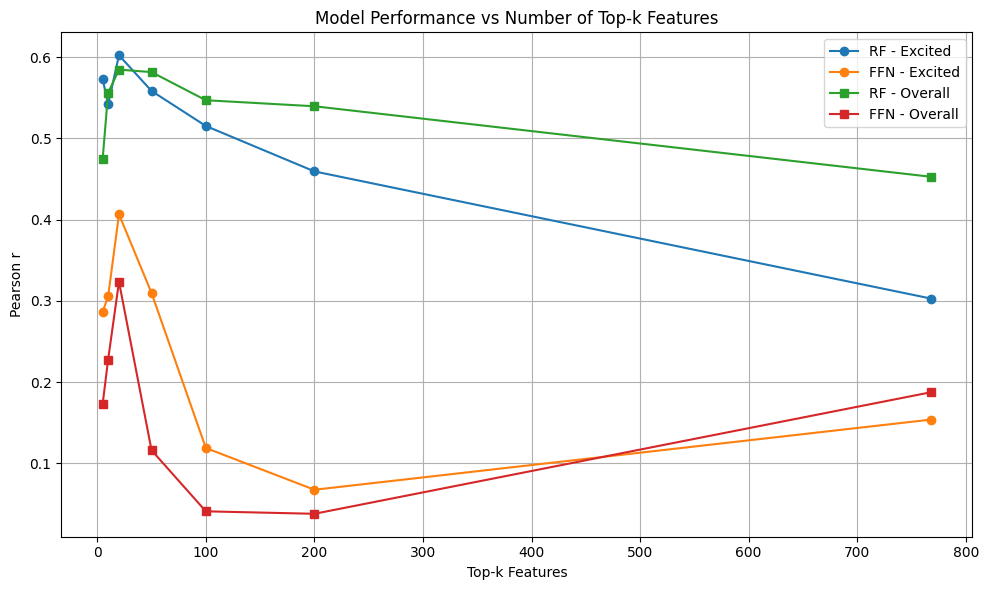

In [ ]:
#Visualizing the results

#Convert your results list into a DataFrame
df_results = pd.DataFrame(results)


plt.figure(figsize=(10, 6))
plt.plot(df_results['k'], df_results['r_rf_exc'], label='RF - Excited', marker='o')
plt.plot(df_results['k'], df_results['r_ffn_exc'], label='FFN - Excited', marker='o')
plt.plot(df_results['k'], df_results['r_rf_ovr'], label='RF - Overall', marker='s')
plt.plot(df_results['k'], df_results['r_ffn_ovr'], label='FFN - Overall', marker='s')



# Axis labels and title
plt.xlabel('Top-k Features')
plt.ylabel('Pearson r')
plt.title('Model Performance vs Number of Top-k Features')

# Legend and grid
plt.legend()
plt.grid(True)

# Tight layout for clean display
plt.tight_layout()
plt.show()


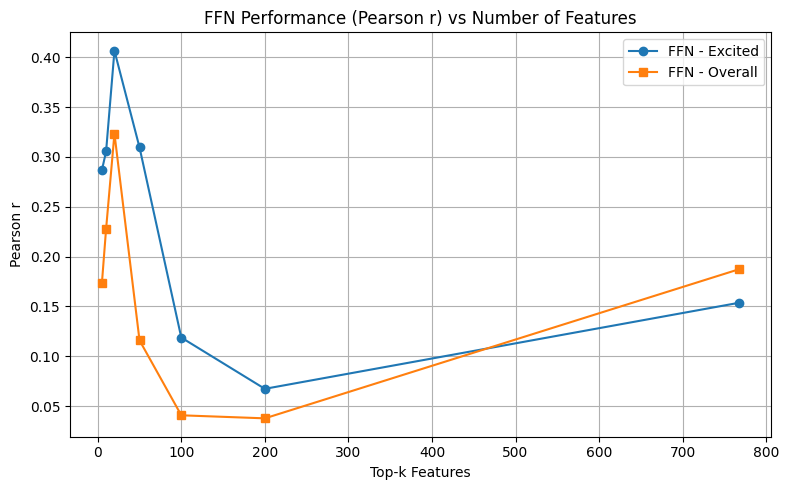

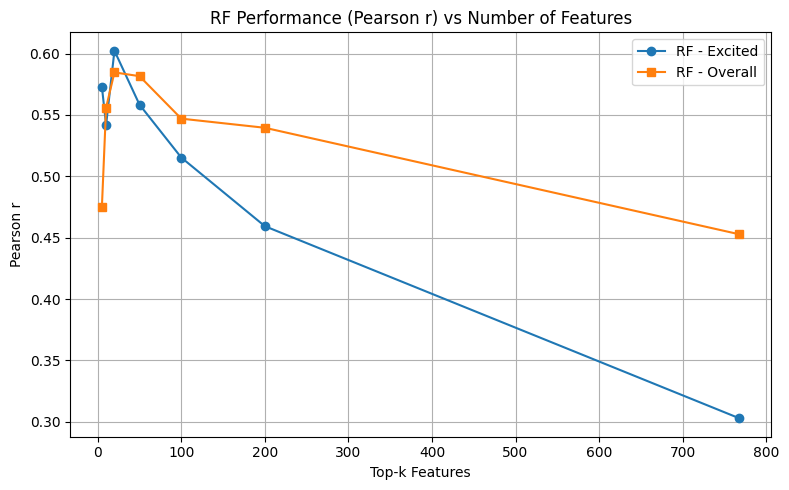

In [ ]:
df = pd.DataFrame(results)

#FFN Plot
plt.figure(figsize=(8, 5))
plt.plot(df['k'], df['r_ffn_exc'], label='FFN - Excited', marker='o')
plt.plot(df['k'], df['r_ffn_ovr'], label='FFN - Overall', marker='s')
plt.xlabel('Top-k Features')
plt.ylabel('Pearson r')
plt.title('FFN Performance (Pearson r) vs Number of Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#RF Plot
plt.figure(figsize=(8, 5))
plt.plot(df['k'], df['r_rf_exc'], label='RF - Excited', marker='o')
plt.plot(df['k'], df['r_rf_ovr'], label='RF - Overall', marker='s')
plt.xlabel('Top-k Features')
plt.ylabel('Pearson r')
plt.title('RF Performance (Pearson r) vs Number of Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Evaluate on test set using best K

In [ ]:
#Best k for RF /based on mean of R for both Excitment and Overall
best_k = None
best_r_mean = -np.inf

for entry in results:
    r_mean = (entry["r_rf_exc"] + entry["r_rf_ovr"]) / 2

    if r_mean > best_r_mean:
        best_r_mean = r_mean
        best_k = entry["k"]

print(f"RF: Best k = {best_k} with mean r = {best_r_mean:.3f}")

#Best k for ffn
best_k = None
best_r_mean = -np.inf

for entry in results:
    r_mean = (entry["r_ffn_exc"] + entry["r_ffn_ovr"]) / 2

    if r_mean > best_r_mean:
        best_r_mean = r_mean
        best_k = entry["k"]

print(f"FFN: Best k = {best_k} with mean r = {best_r_mean:.3f}")

RF: Best k = 20 with mean r = 0.593
FFN: Best k = 20 with mean r = 0.365


In [ ]:
#Run best model on test set

top_k_dims = df_bert_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Index"].tolist()

# Filter dimensions
X_train_filtered = X_train_af[:, top_k_dims]
X_test_filtered = X_test_af[:, top_k_dims]

#TF-IDF
top_k_words = df_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Word"]
top_k_tfidf_indices = [tfidf.vocabulary_[word] for word in top_k_words if word in tfidf.vocabulary_]
X_train_tfidf_k = X_train_tfidf[:, top_k_tfidf_indices]
X_test_tfidf_k = X_test_tfidf[:, top_k_tfidf_indices]

#BERT
top_k_dims = df_bert_corr.reindex(df_bert_corr["r_excited"].abs().sort_values(ascending=False).index).head(best_k)["Index"].tolist()
X_train_bert_k = X_train_bert[:, top_k_dims]
X_test_bert_k = X_test_bert[:, top_k_dims]

#Combine

#Fit scalers on training data
scaler_tfidf = StandardScaler().fit(X_train_tfidf_k)
scaler_bert = StandardScaler().fit(X_train_bert_k)

# Transform both train and test
X_train_combined = np.hstack((
    scaler_tfidf.transform(X_train_tfidf_k),
    scaler_bert.transform(X_train_bert_k)
))

X_test_combined = np.hstack((
    scaler_tfidf.transform(X_test_tfidf_k),
    scaler_bert.transform(X_test_bert_k)
))

#Train RF models
rf_exc = RandomForestRegressor(n_estimators=100, random_state=42)
rf_exc.fit(X_train_combined, y_train_excited)

rf_ovr = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ovr.fit(X_train_combined, y_train_overall)

#Train FFN models
ffn_exc = train_ffn_full(X_train_combined, y_train_excited)
ffn_ovr = train_ffn_full(X_train_combined, y_train_overall)


#Predict on test set
y_pred_rf_exc = rf_exc.predict(X_test_combined)
y_pred_rf_ovr = rf_ovr.predict(X_test_combined)

ffn_exc.eval()
ffn_ovr.eval()

with torch.no_grad():
    y_pred_ffn_exc = ffn_exc(torch.tensor(X_test_combined, dtype=torch.float32)).squeeze().numpy()
    y_pred_ffn_ovr = ffn_ovr(torch.tensor(X_test_combined, dtype=torch.float32)).squeeze().numpy()


# Evaluate
r_rf_exc = pearsonr(y_test_excited, y_pred_rf_exc)[0]
re_rf_exc = np.mean(np.abs(y_pred_rf_exc - y_test_excited)) / np.max(y_test_excited)

r_rf_ovr = pearsonr(y_test_overall, y_pred_rf_ovr)[0]
re_rf_ovr = np.mean(np.abs(y_pred_rf_ovr - y_test_overall)) / np.max(y_test_overall)

r_ffn_exc = pearsonr(y_test_excited, y_pred_ffn_exc)[0]
re_ffn_exc = np.mean(np.abs(y_pred_ffn_exc - y_test_excited)) / np.max(y_test_excited)

r_ffn_ovr = pearsonr(y_test_overall, y_pred_ffn_ovr)[0]
re_ffn_ovr = np.mean(np.abs(y_pred_ffn_ovr - y_test_overall)) / np.max(y_test_overall)

# Print final test results
print(f"Test Set Results (k={best_k}):")
print(f"  Excited → RF:  r = {r_rf_exc:.3f}, RE = {re_rf_exc:.3f} | FFN: r = {r_ffn_exc:.3f}, RE = {re_ffn_exc:.3f}")
print(f"  Overall → RF:  r = {r_rf_ovr:.3f}, RE = {re_rf_ovr:.3f} | FFN: r = {r_ffn_ovr:.3f}, RE = {re_ffn_ovr:.3f}")



Test Set Results (k=20):
  Excited → RF:  r = 0.236, RE = 0.114 | FFN: r = 0.258, RE = 0.148
  Overall → RF:  r = 0.346, RE = 0.083 | FFN: r = 0.252, RE = 0.107


## E: Explainable ML

### LIME on RF:

In [ ]:
top_k_words = df_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Word"]
tfidf_feature_names = list(top_k_words)

n_bert = X_train_bert_k.shape[1]
feature_names = tfidf_feature_names + [f'bert_{i}' for i in range(n_bert)]


In [ ]:
explainer_rf = LimeTabularExplainer(
    training_data=X_train_combined,
    feature_names=feature_names,
    mode='regression',
    verbose=True
)

idx = 3
exp_rf = explainer_rf.explain_instance(
    data_row=X_test_combined[idx],
    predict_fn=rf_exc.predict,
    num_features=10
)

exp_rf.show_in_notebook()


Intercept 4.907132831197084
Prediction_local [5.14202882]
Right: 4.919966104300002


In [ ]:
exp_rf.as_list()

[('bert_1 > 0.72', 0.12341135206317194),
 ('0.04 < bert_5 <= 0.62', 0.10234846953023675),
 ('chemical <= -0.26', -0.09837984095978995),
 ('bert_0 <= -0.61', 0.09370229883574066),
 ('know > 0.19', 0.07868529031836942),
 ('bert_2 > 0.71', -0.07297131791328934),
 ('-0.23 < really <= 0.57', 0.06770252638842353),
 ('bert_9 > 0.70', -0.06254527449921601),
 ('0.06 < bert_4 <= 0.76', 0.061227673174999137),
 ('maybe <= -0.36', -0.058285183893682486)]

### Lime on FFN:

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

explainer_ffn = LimeTabularExplainer(
    training_data=X_train_combined,
    feature_names=feature_names,
    mode='regression',
    verbose=True
)
idx = 3

exp_ffn = explainer_ffn.explain_instance(
    data_row=X_test_combined[idx],
    predict_fn=predict_ffn_exc,
    num_features=10
)

exp_ffn.show_in_notebook()


Intercept 5.159904561068932
Prediction_local [5.08398958]
Right: 4.3531613


In [ ]:
print("Top features for FFN prediction (Excited):")
for feat, weight in exp_ffn.as_list():
    print(f"  {feat}: {weight:.4f}")


Top features for FFN prediction (Excited):
  deadline <= -0.30: -0.4903
  bert_10 <= -0.63: 0.4228
  chemical <= -0.26: -0.3634
  contribute <= -0.34: -0.2909
  know > 0.19: 0.2741
  program > -0.36: -0.2713
  bert_0 <= -0.61: 0.2587
  bert_16 <= -0.73: 0.2498
  instead <= -0.38: -0.1736
  bert_7 > 0.58: 0.1504


## D: Multimodal ML models

Include data cleaning?

In [ ]:
#Load data
prosodic_csv = pd.read_csv(folder_path + "prosodic_features.csv")

#Clean undefined values by removing them
prosodic_csv["avgBand3"] = pd.to_numeric(prosodic_csv["avgBand3"], errors='coerce')
prosodic_csv = prosodic_csv.dropna(subset=["avgBand3"])

#Extract Participant ID
prosodic_csv["Participant"] = (
    prosodic_csv["participant&question"]
    .str.extract(r'(p\d+)', flags=re.IGNORECASE)[0]
    .str.lower()
)

#Select only numeric columns for mean computation
numeric_cols = prosodic_csv.select_dtypes(include='number').columns
prosodic_avg = prosodic_csv[["Participant"] + list(numeric_cols)].groupby("Participant").mean().reset_index()

#Normalize score IDs too
scores_csv["Participant"] = scores_csv["Participant"].str.lower().str.strip()

#Merge with scores
df_prosodic = pd.merge(prosodic_avg, scores_csv, on="Participant", how="inner")


#Extract outcome variables
y_excited = df_prosodic["Excited"].values
y_overall = df_prosodic["Overall"].values

#Remove non-feature columns
feature_cols = [col for col in df_prosodic.columns if col not in ["participant", "Participant", "Excited", "Overall"]]
X_prosodic = df_prosodic[feature_cols].values

#Normalize participant column in df_merge
df_merge["Participant"] = df_merge["Participant"].str.lower().str.strip()

#Build a dict to map each participant to their prosodic feature vector
prosodic_dict = dict(zip(df_prosodic["Participant"], X_prosodic))

#Duplicate the prosodic features so each transcript gets the correct one
X_prosodic_expanded = np.vstack([
    prosodic_dict.get(pid, np.zeros_like(next(iter(prosodic_dict.values())))) for pid in df_merge["Participant"]
])

#Split into training and test set:
X_train_prosodic = X_prosodic_expanded[train_df.index]
X_test_prosodic = X_prosodic_expanded[test_df.index]

#### Only Prosodic:


In [ ]:
#Select top k features for each target - Pearson Filtering
selector_excited = SelectKBest(score_func=f_regression, k=20)
X_top_excited = selector_excited.fit_transform(X_prosodic, y_excited)
selected_feat_names_excited = [feature_cols[i] for i in selector_excited.get_support(indices=True)]

In [ ]:
r_rf_pros_exc, re_rf_pros_exc = train_rf(X_prosodic, y_excited)
r_ffn_pros_exc, re_ffn_pros_exc = train_ffn(X_prosodic, y_excited)

r_rf_pros_ovr, re_rf_pros_ovr = train_rf(X_prosodic, y_overall)
r_ffn_pros_ovr, re_ffn_pros_ovr = train_ffn(X_prosodic, y_overall)

print("Prosodic-only Results:")
print(f"  Excited → RF: r={r_rf_pros_exc:.3f}, RE={re_rf_pros_exc:.3f} | FFN: r={r_ffn_pros_exc:.3f}, RE={re_ffn_pros_exc:.3f}")
print(f"  Overall → RF: r={r_rf_pros_ovr:.3f}, RE={re_rf_pros_ovr:.3f} | FFN: r={r_ffn_pros_ovr:.3f}, RE={re_ffn_pros_ovr:.3f}") #Remove?


Prosodic-only Results:
  Excited → RF: r=0.667, RE=0.081 | FFN: r=0.040, RE=0.209
  Overall → RF: r=0.438, RE=0.073 | FFN: r=-0.384, RE=0.236


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

k_values = [5, 10, 20, 50, 100]
prosodic_results = []

y_train_excited = train_df["Excited"].values
y_train_overall = train_df["Overall"].values

for k in k_values:
    selector_excited = SelectKBest(score_func=f_regression, k=min(k, X_train_prosodic.shape[1]))
    X_pros_k_exc = selector_excited.fit_transform(X_train_prosodic, y_train_excited)

    selector_overall = SelectKBest(score_func=f_regression, k=min(k, X_train_prosodic.shape[1]))
    X_pros_k_ovr = selector_overall.fit_transform(X_train_prosodic, y_train_overall)

    #Models for Excited
    r_rf_exc, re_rf_exc = train_rf(X_pros_k_exc, y_train_excited)
    r_ffn_exc, re_ffn_exc = train_ffn(X_pros_k_exc, y_train_excited)

    #Models for Overall
    r_rf_ovr, re_rf_ovr = train_rf(X_pros_k_ovr, y_train_overall)
    r_ffn_ovr, re_ffn_ovr = train_ffn(X_pros_k_ovr, y_train_overall)

    prosodic_results.append({
        'k': k,
        'r_rf_exc': r_rf_exc, 're_rf_exc': re_rf_exc,
        'r_ffn_exc': r_ffn_exc, 're_ffn_exc': re_ffn_exc,
        'r_rf_ovr': r_rf_ovr, 're_rf_ovr': re_rf_ovr,
        'r_ffn_ovr': r_ffn_ovr, 're_ffn_ovr': re_ffn_ovr
    })

    print(f"k={k} (Prosodic-only):")
    print(f"  Excited → RF: r={r_rf_exc:.3f}, RE={re_rf_exc:.3f} | FFN: r={r_ffn_exc:.3f}, RE={re_ffn_exc:.3f}")
    print(f"  Overall → RF: r={r_rf_ovr:.3f}, RE={re_rf_ovr:.3f} | FFN: r={r_ffn_ovr:.3f}, RE={re_ffn_ovr:.3f}")


k=5 (Prosodic-only):
  Excited → RF: r=0.429, RE=0.091 | FFN: r=0.372, RE=0.102
  Overall → RF: r=0.205, RE=0.080 | FFN: r=0.187, RE=0.084
k=10 (Prosodic-only):
  Excited → RF: r=0.423, RE=0.091 | FFN: r=0.062, RE=0.165
  Overall → RF: r=0.180, RE=0.079 | FFN: r=-0.004, RE=0.131
k=20 (Prosodic-only):
  Excited → RF: r=0.448, RE=0.088 | FFN: r=0.010, RE=0.145
  Overall → RF: r=0.103, RE=0.079 | FFN: r=0.073, RE=0.125
k=50 (Prosodic-only):
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.180, RE=0.145
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.114, RE=0.143
k=100 (Prosodic-only):
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.173, RE=0.169
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.140, RE=0.141


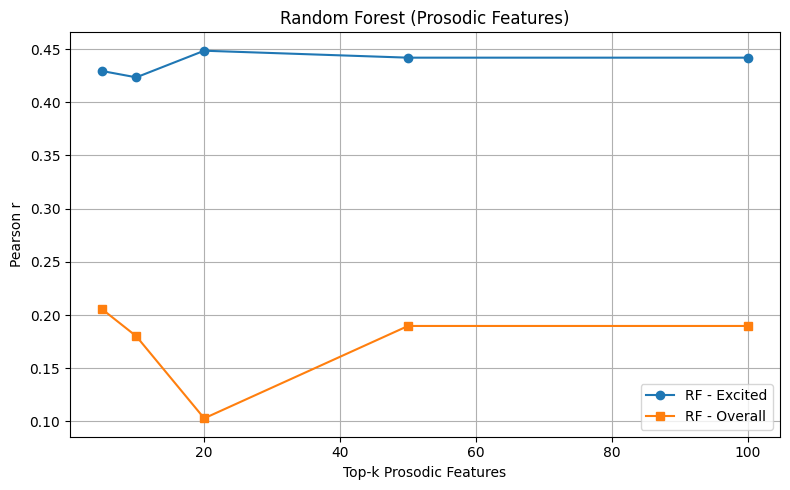

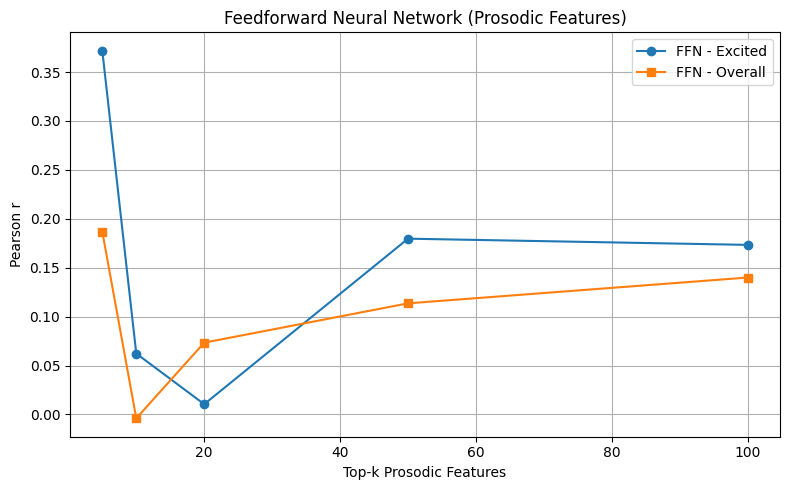

In [ ]:
#Visualize

df_prosodic = pd.DataFrame(prosodic_results)


plt.figure(figsize=(8, 5))
plt.plot(df_prosodic['k'], df_prosodic['r_rf_exc'], label='RF - Excited', marker='o')
plt.plot(df_prosodic['k'], df_prosodic['r_rf_ovr'], label='RF - Overall', marker='s')
plt.xlabel('Top-k Prosodic Features')
plt.ylabel('Pearson r')
plt.title('Random Forest (Prosodic Features)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(df_prosodic['k'], df_prosodic['r_ffn_exc'], label='FFN - Excited', marker='o')
plt.plot(df_prosodic['k'], df_prosodic['r_ffn_ovr'], label='FFN - Overall', marker='s')
plt.xlabel('Top-k Prosodic Features')
plt.ylabel('Pearson r')
plt.title('Feedforward Neural Network (Prosodic Features)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Find best k based on average Pearson r for RF and FFN
best_rf_k = None
best_rf_score = -float("inf")

best_ffn_k = None
best_ffn_score = -float("inf")

for result in prosodic_results:
    mean_r_rf = (result['r_rf_exc'] + result['r_rf_ovr']) / 2
    mean_r_ffn = (result['r_ffn_exc'] + result['r_ffn_ovr']) / 2

    if mean_r_rf > best_rf_score:
        best_rf_score = mean_r_rf
        best_rf_k = result['k']

    if mean_r_ffn > best_ffn_score:
        best_ffn_score = mean_r_ffn
        best_ffn_k = result['k']

print("\nBest k values (Prosodic-only):")
print(f"RF:  k = {best_rf_k}, mean r = {best_rf_score:.3f}")
print(f"FFN: k = {best_ffn_k}, mean r = {best_ffn_score:.3f}")



Best k values (Prosodic-only):
RF:  k = 5, mean r = 0.317
FFN: k = 5, mean r = 0.279


In [ ]:
#Run on test set:

best_k = 5


selector = SelectKBest(score_func=f_regression, k=best_k)
selector.fit(X_train_prosodic, y_train_excited)

#Transform both train and test sets
X_train_selected = selector.transform(X_train_prosodic)
X_test_selected = selector.transform(X_test_prosodic)

#Train models on the full training set
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train_excited)

ffn_model = train_ffn_full(X_train_selected, y_train_excited)


In [ ]:
# Predict on test set
y_pred_rf = rf_model.predict(X_test_selected)

ffn_model.eval()
with torch.no_grad():
    y_pred_ffn = ffn_model(torch.tensor(X_test_selected, dtype=torch.float32)).squeeze().numpy()


r_rf = pearsonr(y_test_excited, y_pred_rf)[0]
re_rf = np.mean(np.abs(y_pred_rf - y_test_excited)) / np.max(y_test_excited)

r_ffn = pearsonr(y_test_excited, y_pred_ffn)[0]
re_ffn = np.mean(np.abs(y_pred_ffn - y_test_excited)) / np.max(y_test_excited)

print(f"Test Set → RF:  r = {r_rf:.3f}, RE = {re_rf:.3f}")
print(f"Test Set → FFN: r = {r_ffn:.3f}, RE = {re_ffn:.3f}")


Test Set → RF:  r = 0.227, RE = 0.115
Test Set → FFN: r = -0.363, RE = 0.149


#### Prosodic + Transcript

In [ ]:
k_values = [5, 10, 20, 50, 100]
multi_results_bf = []

y_excited = y_train_excited
y_overall = y_train_overall

for k in k_values:
    #combine tf-idf-bert-prosody
    #TF-IDF
    top_k_words = df_corr.sort_values(by='r_excited', ascending=False).head(k)["Word"]
    top_k_tfidf_indices = [tfidf.vocabulary_[word] for word in top_k_words if word in tfidf.vocabulary_]
    X_train_tfidf_k = X_train_tfidf[:, top_k_tfidf_indices]


    #BERT
    top_k_dims = df_bert_corr.sort_values(by='r_excited', ascending=False).head(k)["Index"]
    top_k_bert_indices = top_k_dims.tolist()
    X_train_bert_k = X_train_bert[:, top_k_bert_indices]

    #Combine
    X_combined = np.hstack((
        StandardScaler().fit_transform(X_train_tfidf_k),
        StandardScaler().fit_transform(X_train_bert_k)
    ))

    #In your for loop where you already have X_tfidf_k and X_bert_k:
    X_prosodic_scaled = StandardScaler().fit_transform(X_train_prosodic)


    X_multimodal = np.hstack((
        StandardScaler().fit_transform(X_train_tfidf_k),
        StandardScaler().fit_transform(X_train_bert_k),
        X_prosodic_scaled
    ))

    #Run your models on this combined feature set
    r_rf_mm_exc, re_rf_mm_exc = train_rf(X_multimodal, y_excited)
    r_ffn_mm_exc, re_ffn_mm_exc = train_ffn(X_multimodal, y_excited)

    r_rf_mm_ovr, re_rf_mm_ovr = train_rf(X_multimodal, y_overall)
    r_ffn_mm_ovr, re_ffn_mm_ovr = train_ffn(X_multimodal, y_overall)

    #Save to your loop results if needed
    multi_results_bf.append({
    'k': k,
    'r_rf_mm_exc': r_rf_mm_exc, 're_rf_mm_exc': re_rf_mm_exc,
    'r_ffn_mm_exc': r_ffn_mm_exc, 're_ffn_mm_exc': re_ffn_mm_exc,
    'r_rf_mm_ovr': r_rf_mm_ovr, 're_rf_mm_ovr': re_rf_mm_ovr,
    'r_ffn_mm_ovr': r_ffn_mm_ovr, 're_ffn_mm_ovr': re_ffn_mm_ovr
    })

    print(f"k={k}:")
    print(f"  Excited → RF: r={r_rf_exc:.3f}, RE={re_rf_exc:.3f} | FFN: r={r_ffn_exc:.3f}, RE={re_ffn_exc:.3f}")
    print(f"  Overall → RF: r={r_rf_ovr:.3f}, RE={re_rf_ovr:.3f} | FFN: r={r_ffn_ovr:.3f}, RE={re_ffn_ovr:.3f}")


k=5:
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.173, RE=0.169
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.140, RE=0.141
k=10:
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.173, RE=0.169
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.140, RE=0.141
k=20:
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.173, RE=0.169
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.140, RE=0.141
k=50:
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.173, RE=0.169
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.140, RE=0.141
k=100:
  Excited → RF: r=0.442, RE=0.088 | FFN: r=0.173, RE=0.169
  Overall → RF: r=0.190, RE=0.077 | FFN: r=0.140, RE=0.141


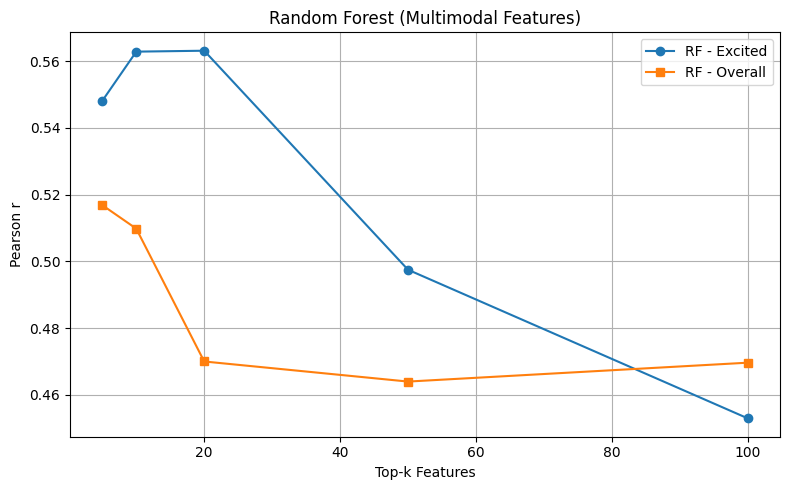

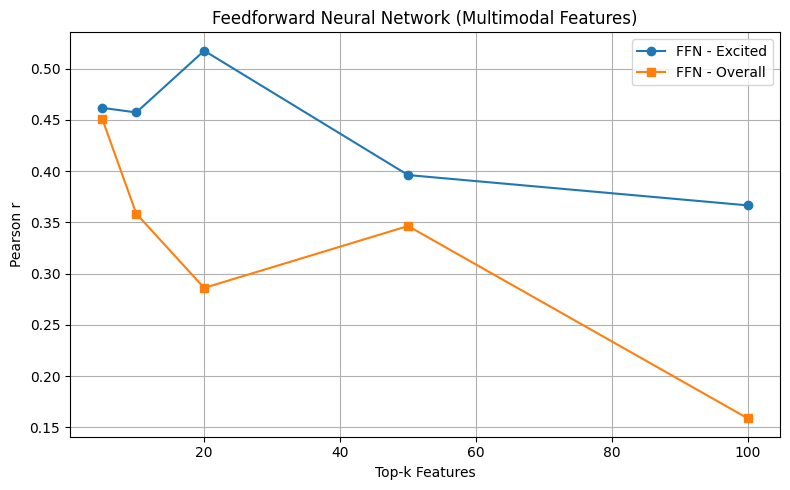

In [ ]:
#Visualize:
df_multi = pd.DataFrame(multi_results_bf)

# --- Plot for Random Forest ---
plt.figure(figsize=(8, 5))
plt.plot(df_multi['k'], df_multi['r_rf_mm_exc'], label='RF - Excited', marker='o')
plt.plot(df_multi['k'], df_multi['r_rf_mm_ovr'], label='RF - Overall', marker='s')
plt.xlabel('Top-k Features')
plt.ylabel('Pearson r')
plt.title('Random Forest (Multimodal Features)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot for Feedforward Neural Network (FFN) ---
plt.figure(figsize=(8, 5))
plt.plot(df_multi['k'], df_multi['r_ffn_mm_exc'], label='FFN - Excited', marker='o')
plt.plot(df_multi['k'], df_multi['r_ffn_mm_ovr'], label='FFN - Overall', marker='s')
plt.xlabel('Top-k Features')
plt.ylabel('Pearson r')
plt.title('Feedforward Neural Network (Multimodal Features)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
best_rf_k = None
best_rf_r = -np.inf

best_ffn_k = None
best_ffn_r = -np.inf

for result in multi_results_bf:
    # Average r for RF (Excited + Overall)
    r_mean_rf = (result["r_rf_mm_exc"] + result["r_rf_mm_ovr"]) / 2

    # Average r for FFN (Excited + Overall)
    r_mean_ffn = (result["r_ffn_mm_exc"] + result["r_ffn_mm_ovr"]) / 2

    # Update best for RF
    if r_mean_rf > best_rf_r:
        best_rf_r = r_mean_rf
        best_rf_k = result["k"]

    # Update best for FFN
    if r_mean_ffn > best_ffn_r:
        best_ffn_r = r_mean_ffn
        best_ffn_k = result["k"]

print(f"Best k for RF: {best_rf_k} with mean r = {best_rf_r:.3f}")
print(f"Best k for FFN: {best_ffn_k} with mean r = {best_ffn_r:.3f}")


Best k for RF: 10 with mean r = 0.536
Best k for FFN: 5 with mean r = 0.456


In [ ]:
#TEST RF
best_k = best_rf_k

#TF-IDF
top_k_words = df_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Word"]
top_k_tfidf_indices = [tfidf.vocabulary_[word] for word in top_k_words if word in tfidf.vocabulary_]
X_train_tfidf_k = X_train_tfidf[:, top_k_tfidf_indices]
X_test_tfidf_k = X_test_tfidf[:, top_k_tfidf_indices]

#BERT
top_k_dims = df_bert_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Index"].tolist()
X_train_bert_k = X_train_bert[:, top_k_dims]
X_test_bert_k = X_test_bert[:, top_k_dims]

#Prosodic
scaler_prosodic = StandardScaler().fit(X_train_prosodic)
X_train_prosodic_scaled = scaler_prosodic.transform(X_train_prosodic)
X_test_prosodic_scaled = scaler_prosodic.transform(X_test_prosodic)

#Scale and combine all
scaler_tfidf = StandardScaler().fit(X_train_tfidf_k)
scaler_bert = StandardScaler().fit(X_train_bert_k)

X_train_combined = np.hstack([
    scaler_tfidf.transform(X_train_tfidf_k),
    scaler_bert.transform(X_train_bert_k),
    X_train_prosodic_scaled
])
X_test_combined = np.hstack([
    scaler_tfidf.transform(X_test_tfidf_k),
    scaler_bert.transform(X_test_bert_k),
    X_test_prosodic_scaled
])

#Train RF
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_combined, y_train_excited)

#evaluate
y_pred_rf = rf_model.predict(X_test_combined)
r_rf = pearsonr(y_test_excited, y_pred_rf)[0]
re_rf = np.mean(np.abs(y_pred_rf - y_test_excited)) / np.max(y_test_excited)




In [ ]:
#TEST FFN
best_k = best_ffn_k

#Same top-k selection
top_k_words = df_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Word"]
top_k_tfidf_indices = [tfidf.vocabulary_[word] for word in top_k_words if word in tfidf.vocabulary_]
X_train_tfidf_k = X_train_tfidf[:, top_k_tfidf_indices]
X_test_tfidf_k = X_test_tfidf[:, top_k_tfidf_indices]

top_k_dims = df_bert_corr.sort_values(by='r_excited', ascending=False).head(best_k)["Index"].tolist()
X_train_bert_k = X_train_bert[:, top_k_dims]
X_test_bert_k = X_test_bert[:, top_k_dims]

#Prosodic reuse
X_train_prosodic_scaled = scaler_prosodic.transform(X_train_prosodic)
X_test_prosodic_scaled = scaler_prosodic.transform(X_test_prosodic)

#Combine & scale
scaler_tfidf = StandardScaler().fit(X_train_tfidf_k)
scaler_bert = StandardScaler().fit(X_train_bert_k)

X_train_combined = np.hstack([
    scaler_tfidf.transform(X_train_tfidf_k),
    scaler_bert.transform(X_train_bert_k),
    X_train_prosodic_scaled
])
X_test_combined = np.hstack([
    scaler_tfidf.transform(X_test_tfidf_k),
    scaler_bert.transform(X_test_bert_k),
    X_test_prosodic_scaled
])

#Train FFN
ffn_model = train_ffn_full(X_train_combined, y_train_excited)

#Predict & evaluate
ffn_model.eval()
with torch.no_grad():
    y_pred_ffn = ffn_model(torch.tensor(X_test_combined, dtype=torch.float32)).squeeze().numpy()

r_ffn = pearsonr(y_test_excited, y_pred_ffn)[0]
re_ffn = np.mean(np.abs(y_pred_ffn - y_test_excited)) / np.max(y_test_excited)


In [ ]:
print(f"\nTest Set Results:")
print(f"  RF (k={best_rf_k}) → r = {r_rf:.3f}, RE = {re_rf:.3f}")
print(f"  FFN (k={best_ffn_k}) → r = {r_ffn:.3f}, RE = {re_ffn:.3f}")


Test Set Results:
  RF (k=10) → r = 0.495, RE = 0.106
  FFN (k=5) → r = -0.169, RE = 0.147
